# PicTex Text Detection Model with Zach

Finalized on **August 21st, 2020**


### 1. Create labels

In [8]:
from collections import OrderedDict
import numpy as np
import torch
import os

data_dir = "./final/"

classes = os.listdir(data_dir)
num_classes = len(classes)

classes_encode, classes_decode = {}, {}
for i, name in enumerate(classes):
    classes_encode[name] = i
    classes_decode[i] = name

encode_dict, decode_dict = OrderedDict(classes_encode), OrderedDict(classes_encode)

print(f"There are {num_classes} classes")
print(classes_encode)
print(classes_decode)

There are 73 classes
{'(': 0, ')': 1, '+': 2, '-': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, '=': 14, 'a': 15, 'alpha': 16, 'ast': 17, 'b': 18, 'beta': 19, 'c': 20, 'comma': 21, 'd': 22, 'delta': 23, 'e': 24, 'emptyset': 25, 'f': 26, 'forall': 27, 'full_stop': 28, 'g': 29, 'greater': 30, 'h': 31, 'implies': 32, 'in': 33, 'infty': 34, 'int': 35, 'j': 36, 'k': 37, 'l': 38, 'lambda': 39, 'land': 40, 'leq': 41, 'lesser': 42, 'm': 43, 'mu': 44, 'n': 45, 'nabla': 46, 'Naturals': 47, 'neq': 48, 'o': 49, 'p': 50, 'perp': 51, 'pi': 52, 'q': 53, 'r': 54, 'Reals': 55, 's': 56, 'setminus': 57, 'sigma': 58, 'sim': 59, 'sum': 60, 'supset': 61, 't': 62, 'theta': 63, 'u': 64, 'v': 65, 'varepsilon': 66, 'w': 67, 'x': 68, 'y': 69, 'z': 70, '[': 71, ']': 72}
{0: '(', 1: ')', 2: '+', 3: '-', 4: '0', 5: '1', 6: '2', 7: '3', 8: '4', 9: '5', 10: '6', 11: '7', 12: '8', 13: '9', 14: '=', 15: 'a', 16: 'alpha', 17: 'ast', 18: 'b', 19: 'beta', 20: 'c', 21: 'comma', 22:

### 2. Create the `Dataset` and `Dataloader` objects

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import numpy as np
import torch
from PIL import Image
import random

# grayscale images have one channel
num_output_channels = 1
normal = (0.5,)

# choose batch size
batch_size = 64

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels),
     transforms.Resize((32, 32)), 
     transforms.ToTensor(),
     transforms.Normalize(normal, normal)])

class PicTexDataset(Dataset):
    def __init__(self, root_dir, encode_dict, num_classes, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory containing images sorted by class folders
            encode_dict (Ordered dict): Dictionary with class names zipped from 0-(num_classes-1)
            num_classes (int): Number of classes (SHOULD EQUAL LEN of ENCODE_DICT)
            transform (torchvision.transforms): Transforms to be applied to images 
        """
        self.root_dir = root_dir
        self.encode_dict = encode_dict
        self.num_classes = num_classes
        self.transform = transform
        self.is_train = train
        
        """
        Loading images:
            all_paths (string list): Path of every image
            all_paths_class (string list): Bijection with all_paths. Class name for each path
            all_images (string * string list): List of these objects... (class name, path of image)
        """
        all_paths, all_paths_class = [], []
        for name in encode_dict.keys():
            list_classes = os.listdir(root_dir + name)
            all_paths += list(map(lambda s : root_dir + name + "/" + s, list_classes))
            all_paths_class += [name] * len(list_classes)
        
        self.all_images = list(zip(all_paths_class, all_paths))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_class, img_name = self.all_images[idx]
        try:
            image = Image.open(img_name)
            if self.is_train:
                image = self.random_shift(image)
            if self.transform:
                image = self.transform(image)
        except OSError:
            print(img_name, img_class)
        
        """
        label:
            If we wanted a tensor with a 1 in the spot of the class
            just uncomment the old label definition
            but NLLoss and CrossEntropyLoss just want the index
        """
        #label = torch.zeros(self.num_classes)
        #label[self.encode_dict[img_class]] = 1 
        label = self.encode_dict[img_class]
        
        return image, label
    
    def random_shift(self, img):
        if random.random() < 0.5:
            return img

        img = np.array(img)
        h, w = img.shape
        img_out = np.zeros((h, w), dtype=np.double)

        dx = random.uniform(-w*0.15, w*0.15)
        dy = random.uniform(-h*0.15, h*0.15)
        dx, dy = int(dx), int(dy)

        if dx >= 0 and dy >= 0:
            img_out[dy:, dx:] = img[:h-dy, :w-dx]
        elif dx >= 0 and dy < 0:
            img_out[:h+dy, dx:] = img[-dy:, :w-dx]
        elif dx < 0 and dy >= 0:
            img_out[dy:, :w+dx] = img[:h-dy, -dx:]
        elif dx < 0 and dy < 0:
            img_out[:h+dy, :w+dx] = img[-dy:, -dx:]

        img_out = Image.fromarray(img_out) 
        return img_out
        
    
def load_split_train_test(datadir, valid_size = .2):
    dataset = PicTexDataset(data_dir, encode_dict, num_classes, transform)
    num_test = int(valid_size*len(dataset))
    num_train = len(dataset) - num_test
    
    train_data, test_data = random_split(dataset, (num_train, num_test))
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .15)


### 3. Test `Dataloader`

In [10]:
for image, label in trainloader:
    print(f"Label: {label}")

Label: tensor([33, 59, 54, 33, 56, 69, 64, 52, 36,  6,  5, 11, 43, 63, 24,  7, 24, 69,
        43,  2, 71, 48, 53, 17, 64, 44,  8, 31, 35, 54, 62, 62, 55, 40, 32, 15,
        66, 50, 14,  6,  3, 21, 45, 56, 32, 11, 38, 47, 18, 22, 31, 22, 54, 14,
        24, 36, 11, 64,  6, 29, 43, 51, 35, 61])
Label: tensor([61, 12, 65, 38, 26, 70, 54,  4, 67, 22, 62, 26, 24,  6, 58, 22, 61, 10,
        69, 27, 23, 60, 23, 37, 39, 70, 51, 36, 68, 49, 30, 34, 64, 31, 34, 15,
        12, 59, 50, 45, 18, 42, 32,  9, 58, 42, 13, 45, 70, 44, 31, 62, 29, 68,
        71, 16, 34, 41, 11,  6, 17, 22, 30, 34])
Label: tensor([46, 61, 33, 43, 23, 11, 18, 33, 48, 55, 52, 47, 26,  8,  1, 58, 14, 16,
        54, 49, 21,  8, 47, 67, 49, 13,  9, 18,  7, 45, 72,  0,  9,  8, 13, 54,
        34, 57, 14, 59, 33, 56, 61, 70, 69, 20, 42, 18, 46, 24, 39, 68, 11, 12,
        52,  2, 68,  9, 51, 15, 37, 23, 47, 30])
Label: tensor([11,  4, 29, 29, 49,  9, 52, 58, 38, 65, 62, 50, 49,  6, 45, 40, 50,  0,
        68, 54,  6, 64,  

Label: tensor([30, 19, 51, 45, 61,  9, 54, 61, 61, 70, 69, 54, 56,  3, 14, 66, 55, 22,
        59, 39, 47, 13, 57, 19, 59, 23, 62,  0, 11, 35, 24, 60, 38, 45, 27, 55,
        48, 32, 34, 45, 49,  9,  0, 69, 46, 12, 14, 24,  5, 40, 46, 67, 43, 34,
        67, 63, 63, 43, 66, 19, 30, 30, 27,  2])
Label: tensor([34, 29, 61, 70, 38,  0,  1, 30, 30, 34, 32, 32, 15, 11, 44,  7, 64, 48,
        24, 23, 44, 69, 32, 60, 51, 34, 51,  8, 10, 15, 64, 57, 58, 63, 62, 56,
        16,  1, 54, 46, 33, 32, 14, 49, 45, 12, 48, 25, 66, 23, 53, 49, 14,  6,
        57, 47, 69, 61,  5,  5, 53,  9, 26, 48])
Label: tensor([60, 70, 25, 25, 34, 26,  4, 60, 47, 52,  4, 14,  3, 25, 25, 17, 69, 20,
        59, 11, 57, 12,  7, 63, 34, 24, 47, 26,  6, 65, 63, 55, 10, 45, 26, 70,
         5, 52, 19, 38, 47, 26, 15,  6, 33, 10, 11, 49, 42, 68, 23,  9, 37,  7,
        65, 34, 17, 66,  3, 14, 42, 63, 44, 24])
Label: tensor([ 7, 17, 27, 57, 44, 44, 17, 60, 10, 55, 28, 46,  8, 22, 47, 30, 40, 33,
        38, 57, 61, 43,  

Label: tensor([69, 24,  6, 26, 17, 21, 47, 18, 58, 51, 68,  9, 26, 16, 55, 30, 44, 57,
        19,  8, 40, 36, 11, 52, 66, 26,  6, 42, 55, 70, 40, 38, 64, 63, 38, 61,
        11, 45,  9, 18, 20, 62, 51, 67, 22,  3, 72, 31, 40,  2, 37, 68, 26, 25,
        66, 42, 66, 48, 52, 17, 54, 37,  3, 72])
Label: tensor([42, 47, 61, 69, 18, 48, 53, 70, 63,  0, 19, 12,  3, 55, 10, 40,  3, 39,
        37, 51, 13, 59,  9, 36, 54, 70, 26, 23, 47, 51,  4, 39, 38, 15, 36, 12,
        18,  0, 30, 38, 55, 68, 45,  7, 51, 67, 64, 42, 59, 66, 64, 45,  7, 68,
        39, 16, 62, 37, 71, 21, 61, 57, 53, 49])
Label: tensor([62, 65, 12, 57, 48, 17, 12, 39, 70,  1, 70,  5, 36, 55, 70, 58, 46, 50,
        56, 64,  3,  1, 27, 47, 13, 22, 14, 53, 68, 10, 54, 45, 21, 64, 30, 53,
        66, 61, 23,  5, 58, 29, 14, 46, 46, 29,  5, 69, 25, 51, 57, 38, 71, 63,
        18, 16, 23, 64,  1, 36, 46, 49, 60, 15])
Label: tensor([19, 41, 66, 65, 27, 40, 44, 11, 22, 51, 56, 20, 61,  7, 43,  4, 53, 46,
         5, 33, 10, 10, 1

### 4. Everything else from before:

Net(
  (conv11): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(20, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv32): Conv2d(80, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=F

c:\users\zacan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


|  [Epoch: 1, Batch: 10]   Train loss: 0.522  |  Test loss: 4.138  |  Test accuracy: 0.021  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.512  |  Test loss: 4.072  |  Test accuracy: 0.013  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.495  |  Test loss: 4.010  |  Test accuracy: 0.020  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.485  |  Test loss: 3.903  |  Test accuracy: 0.029  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.466  |  Test loss: 3.372  |  Test accuracy: 0.103  |
|  [Epoch: 1, Batch: 60]   Train loss: 0.461  |  Test loss: 3.305  |  Test accuracy: 0.130  |
|  [Epoch: 1, Batch: 70]   Train loss: 0.457  |  Test loss: 3.319  |  Test accuracy: 0.083  |
|  [Epoch: 1, Batch: 80]   Train loss: 0.446  |  Test loss: 3.226  |  Test accuracy: 0.087  |
=========================================END TRAINING========================================


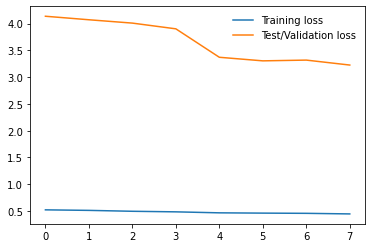

In [17]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(in_channels=num_output_channels, out_channels=20, kernel_size=5, padding=2)
        self.conv12 = nn.Conv2d(20, 20, 5, padding=2)
        self.batch1 = nn.BatchNorm2d(20)
        self.pool1  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv21 = nn.Conv2d(20, 40, 5, padding=2)
        self.conv22 = nn.Conv2d(40, 40, 5, padding=2)
        self.batch2 = nn.BatchNorm2d(40)
        self.pool2  = nn.MaxPool2d(2,2)
        self.conv31 = nn.Conv2d(40, 80, 5, padding=2)
        self.conv32 = nn.Conv2d(80, 80, 5, padding=2)
        self.batch3 = nn.BatchNorm2d(80)
        self.pool3  = nn.MaxPool2d(2,2)
        
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        
        self.fc1 = nn.Linear(80 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        self.dropconv = nn.Dropout(0.2)
        self.dropfc = nn.Dropout(0.4)
        # self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.batch1(x)
        x = self.pool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.batch2(x)
        x = self.pool2(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.batch3(x)
        x = self.pool3(x)
        x = x.view(-1, 80 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropfc(x)
        # x = self.soft(x) --WAS THIS
        return x

# init the class 
model = Net()
print(model)
model.eval()
inp = torch.randn((1,1,32,32))
out = model(inp)

#model.load_state_dict(torch.load('./models/custom_label_1002.pt'))
model.train()
import torch.optim as optim

# set parameters
learning_rate = 0.005
momentum = 0.9

def loss_optim():
    # Loss function: 
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    # criterion = nn.NLLLoss() --WAS THIS
    
    # Optimizer:
    #optimizer = torch.optim.Adamax(model.parameters(), learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    optimizer = optim.Adam(model.parameters(), learning_rate, amsgrad = True)
    #optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable


def train_network():
    
    # Choose parameters
    num_epoch = 1
    mini_batch = 10 # previously batch_size
    train_losses, test_losses = [], []
    running_loss = 0
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # convert to float bc softmax doesn't work with long
            inputs = torch.tensor(inputs, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch-1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        if labels_test.size()[0] == batch_size:
                            ps = model.forward(inputs_test)
                            batch_loss = criterion(ps, labels_test)
                            test_loss += batch_loss.item()
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels_test.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictexHELP_100.pt'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses, PATH

def visualize_train(train_losses, test_losses):
     plt.plot(train_losses, label='Training loss')
     plt.plot(test_losses, label='Test/Validation loss')
     plt.legend(frameon=False)
     plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses, PATH = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)